In [ ]:
import torch
from transformers import PreTrainedModel, AutoTokenizer
from typing import List, Dict, Set, Tuple
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from llm_unlearning.unlearning_datasets.tofu import TofuDataset
from llm_unlearning.evals.utils import extract_question_tokens, extract_answer_tokens
from llm_unlearning.models.models import load_model_and_tokenizer as lib_load_model_and_tokenizer

def load_model_and_tokenizer(model_path: str = "locuslab/tofu_ft_phi-1.5"):
    config = OmegaConf.create({
        "path": model_path,
        "tokenizer_path": "microsoft/phi-1_5",
        "fp16": True
    })
    model, tokenizer = lib_load_model_and_tokenizer(config)
    model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
    return model, tokenizer

def load_tofu_dataset(tokenizer: AutoTokenizer) -> TofuDataset:
    config = OmegaConf.create({
        "split": "full",
        "max_length": 512,
        "question_key": "question",
        "answer_key": "answer",
        "question_start_tag": "Question: ",
        "question_end_tag": "\nAnswer: ",
        "answer_tag": ""
    })
    return TofuDataset(tokenizer, config)

def identify_copy_tokens(question_ids: torch.Tensor, answer_ids: torch.Tensor,
                           pad_token_id: int, check_prefix: bool = True) -> Set[int]:
    question_tokens = [t.item() for t in question_ids[0] if t.item() != pad_token_id]
    answer_tokens = [t.item() for t in answer_ids[0] if t.item() != pad_token_id]

    base_copies = set(question_tokens).intersection(set(answer_tokens))
    if not check_prefix:
        return base_copies

    prefix_copies = set()
    for i, q_token in enumerate(question_tokens[1:], 1):
        if q_token not in base_copies: continue
        q_prefix = question_tokens[i-1]

        for j, a_token in enumerate(answer_tokens[1:], 1):
            if a_token == q_token and answer_tokens[j-1] == q_prefix:
                prefix_copies.add(q_token)
                break

    return prefix_copies

def compute_token_logprobs(model: PreTrainedModel, 
                          input_ids: torch.Tensor,
                          attention_mask: torch.Tensor) -> Dict[int, float]:
    device = next(model.parameters()).device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    log_probs = torch.log_softmax(logits, dim=-1)
    token_log_probs = {}
    for pos in range(input_ids.shape[1] - 1):
        next_token = input_ids[0, pos + 1].item()
        token_log_probs[pos] = log_probs[0, pos, next_token].item()

    return token_log_probs

def analyze_logprob_distributions(dataset, model, tokenizer, num_samples: int = 400):
    copy_probs = []
    non_copy_probs = []
    samples = range(len(dataset)) if num_samples is None else range(min(num_samples, len(dataset)))

    for idx in tqdm(samples, desc="Computing probs"):
        sample = dataset[idx]
        for key in sample:
            if isinstance(sample[key], torch.Tensor):
                sample[key] = sample[key].unsqueeze(0)

        question_ids, _ = extract_question_tokens(sample, tokenizer.pad_token_id)
        answer_ids = extract_answer_tokens(sample["input_ids"],
                                         sample["question_length"],
                                         tokenizer.pad_token_id)

        copy_token_ids = identify_copy_tokens(question_ids, answer_ids, tokenizer.pad_token_id)
        probs = compute_token_logprobs(model, sample["input_ids"], sample["attention_mask"])

        question_length = sample["question_length"].item()
        for pos in probs.keys():
            if pos >= question_length:
                next_token = sample["input_ids"][0, pos + 1].item()
                if next_token == tokenizer.pad_token_id: continue
                prob = probs[pos]

                if next_token in copy_token_ids:
                    copy_probs.append(prob)
                else:
                    non_copy_probs.append(prob)

    return copy_probs, non_copy_probs

def plot_logprob_distributions(copy_logprobs, non_copy_logprobs, bins=50):
    plt.figure(figsize=(12, 6))

    plt.hist(non_copy_logprobs, bins=bins, alpha=0.5, label='Non-copy tokens',
             density=True, color='blue')
    plt.hist(copy_logprobs, bins=bins, alpha=0.5, label='Copy tokens',
             density=True, color='red')

    plt.xlabel('Log Probability')
    plt.ylabel('Density')
    plt.title('Distribution of Token Log Probabilities')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add mean lines
    plt.axvline(np.mean(copy_logprobs), color='red', linestyle='--', alpha=0.8,
                label=f'Copy mean: {np.mean(copy_logprobs):.2f}')
    plt.axvline(np.mean(non_copy_logprobs), color='blue', linestyle='--', alpha=0.8,
                label=f'Non-copy mean: {np.mean(non_copy_logprobs):.2f}')

    plt.tight_layout()
    return plt.gcf()

In [34]:
model, tokenizer = load_model_and_tokenizer("microsoft/phi-1_5")
dataset = load_tofu_dataset(tokenizer)

Loading model from Hugging Face Hub: microsoft/phi-1_5
Loading tokenizer from Hugging Face Hub: microsoft/phi-1_5


Computing probs: 100%|██████████| 400/400 [00:22<00:00, 17.67it/s]


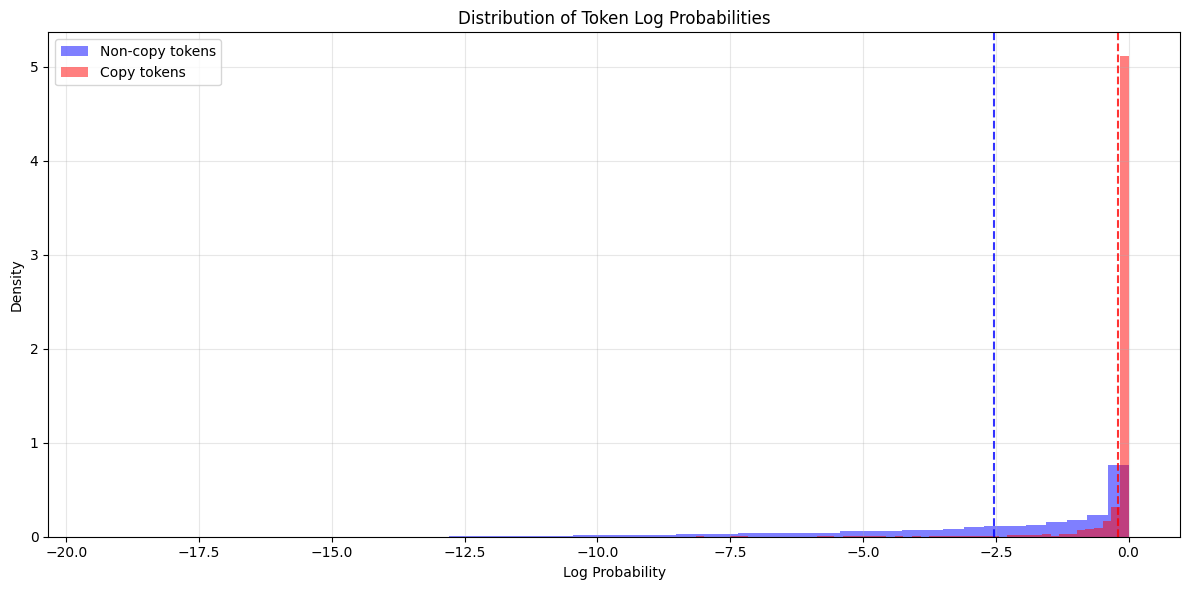


Summary Statistics:

Copy tokens:
Mean: -0.195
Std: 0.690
Count: 2034

Non-copy tokens:
Mean: -2.540
Std: 2.876
Count: 10719


In [35]:
copy_logprobs, non_copy_logprobs = analyze_logprob_distributions(
    dataset=dataset,
    model=model,
    tokenizer=tokenizer,
    num_samples=400
)

# Plot and display results
fig = plot_logprob_distributions(copy_logprobs, non_copy_logprobs)
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("\nCopy tokens:")
print(f"Mean: {np.mean(copy_logprobs):.3f}")
print(f"Std: {np.std(copy_logprobs):.3f}")
print(f"Count: {len(copy_logprobs)}")

print("\nNon-copy tokens:")
print(f"Mean: {np.mean(non_copy_logprobs):.3f}")
print(f"Std: {np.std(non_copy_logprobs):.3f}")
print(f"Count: {len(non_copy_logprobs)}")

In [62]:
copy_logprobs.sort(reverse=True)
non_copy_logprobs.sort(reverse=True)

percent = 50
top_copy_mean = np.mean(copy_logprobs[:len(copy_logprobs) * percent // 100])
top_non_copy_mean = np.mean(non_copy_logprobs[:len(non_copy_logprobs) * percent // 100])


print(f"\nTop {percent}% of copy tokens:")
print(f"Mean: {top_copy_mean:.10f}")
# as probability
print(f"Probability: {np.exp(top_copy_mean):.10f}")

print(f"\nTop {percent}% of non-copy tokens:")
print(f"Mean: {top_non_copy_mean:.10f}")
print(f"Probability: {np.exp(top_non_copy_mean):.10f}")


Top 50% of copy tokens:
Mean: -0.0009007752
Probability: 0.9990996304

Top 50% of non-copy tokens:
Mean: -0.4200671863
Probability: 0.6570026767


In [ ]:
copy_probs_list, non_copy_probs_list = analyze_logprob_distributions(dataset, model, tokenizer, num_samples=400)
copy_probs_list.sort(reverse=True)
non_copy_probs_list.sort(reverse=True)

Computing probabilities: 100%|██████████| 400/400 [00:36<00:00, 11.08it/s]


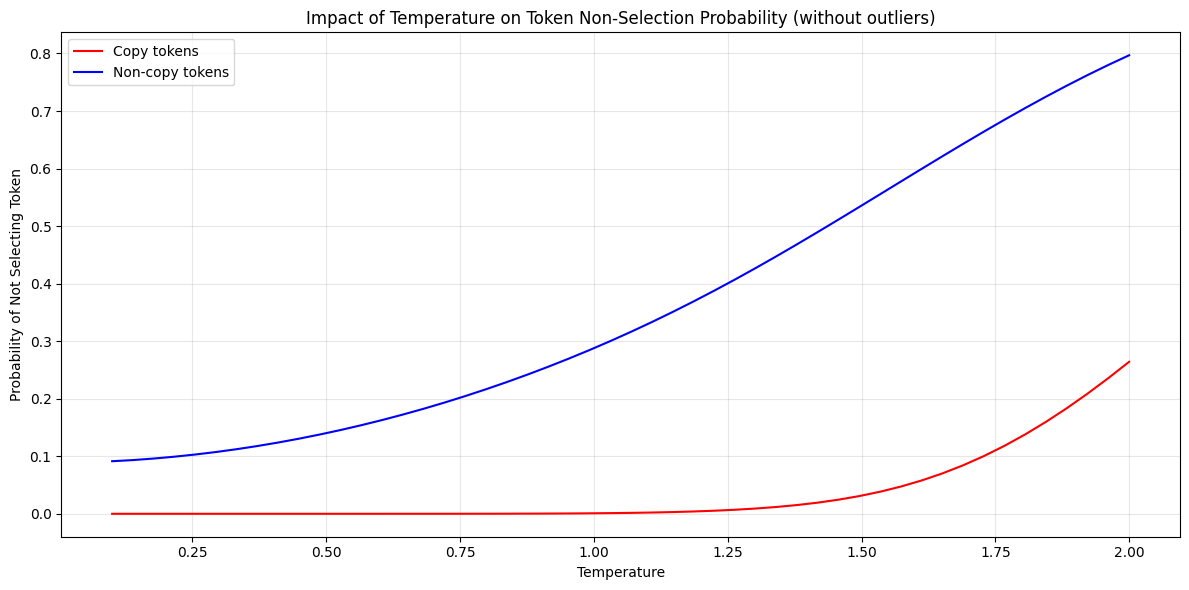

In [84]:
def analyze_temperature_impact(dataset, model, tokenizer, temperatures: List[float], copy_threshold: float, non_copy_threshold: float, num_samples: int = 400):
    copy_probs_sum = {t: 0.0 for t in temperatures}
    non_copy_probs_sum = {t: 0.0 for t in temperatures}
    copy_count = 0
    non_copy_count = 0

    samples = range(len(dataset)) if num_samples is None else range(min(num_samples, len(dataset)))

    for idx in tqdm(samples, desc="Computing probabilities"):
        sample = dataset[idx]
        for key in sample:
            if isinstance(sample[key], torch.Tensor):
                sample[key] = sample[key].unsqueeze(0)

        question_ids, _ = extract_question_tokens(sample, tokenizer.pad_token_id)
        answer_ids = extract_answer_tokens(sample["input_ids"], sample["question_length"], tokenizer.pad_token_id)
        copy_token_ids = identify_copy_tokens(question_ids, answer_ids, tokenizer.pad_token_id)

        device = next(model.parameters()).device
        input_ids = sample["input_ids"].to(device)
        attention_mask = sample["attention_mask"].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

        question_length = sample["question_length"].item()
        for pos in range(input_ids.shape[1] - 1):
            if pos >= question_length:
                next_token = input_ids[0, pos + 1].item()
                if next_token == tokenizer.pad_token_id:
                    continue

                pos_logits = logits[0, pos, :]
                log_prob = torch.log_softmax(pos_logits, dim=-1)[next_token].item()

                if next_token in copy_token_ids and log_prob >= copy_threshold:
                    for temp in temperatures:
                        scaled_logits = pos_logits / temp
                        probs = torch.softmax(scaled_logits, dim=-1)
                        non_selection_prob = 1 - probs[next_token].item()
                        copy_probs_sum[temp] += non_selection_prob
                        if temp == temperatures[0]:
                            copy_count += 1
                elif next_token not in copy_token_ids and log_prob >= non_copy_threshold:
                    for temp in temperatures:
                        scaled_logits = pos_logits / temp
                        probs = torch.softmax(scaled_logits, dim=-1)
                        non_selection_prob = 1 - probs[next_token].item()
                        non_copy_probs_sum[temp] += non_selection_prob
                        if temp == temperatures[0]:
                            non_copy_count += 1

    copy_avg_probs = {t: copy_probs_sum[t] / copy_count if copy_count > 0 else 0.0 for t in temperatures}
    non_copy_avg_probs = {t: non_copy_probs_sum[t] / non_copy_count if non_copy_count > 0 else 0.0 for t in temperatures}

    return copy_avg_probs, non_copy_avg_probs

def plot_temperature_impact(copy_probs: Dict[float, float], non_copy_probs: Dict[float, float], percent: int = 50):
    temperatures = sorted(copy_probs.keys())
    plt.figure(figsize=(12, 6))
    plt.plot(temperatures, [copy_probs[t] for t in temperatures], label='Copy tokens', color='red')
    plt.plot(temperatures, [non_copy_probs[t] for t in temperatures], label='Non-copy tokens', color='blue')
    plt.xlabel('Temperature')
    plt.ylabel('Probability of Not Selecting Token')
    plt.title(f'Impact of Temperature on Token Non-Selection Probability (without outliers)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

percent = 50

copy_idx = max(1, int(len(copy_probs_list) * percent // 100))
non_copy_idx = max(1, int(len(non_copy_probs_list) * percent // 100))

copy_threshold = copy_probs_list[copy_idx - 1]
non_copy_threshold = non_copy_probs_list[non_copy_idx - 1]

temperatures = np.linspace(0.1, 2.0, 50)
copy_probs, non_copy_probs = analyze_temperature_impact(dataset, model, tokenizer, temperatures, copy_threshold, non_copy_threshold)

fig = plot_temperature_impact(copy_probs, non_copy_probs, percent=percent)
plt.show()

In [86]:
import json

results_dict = {
    "copy_threshold": copy_threshold,
    "non_copy_threshold": non_copy_threshold,
    "copy_probs": copy_probs,
    "non_copy_probs": non_copy_probs
}

with open("temperature_impact_results.json", "w") as f:
    json.dump(results_dict, f, indent=2)